# Information about this notebook

This notebook is taken from the [DNA Diffusion project to filter the DHSs by tissue types](https://github.com/pinellolab/DNA-Diffusion/blob/main/notebooks/filter_master.ipynb "The DNA Diffusion Project").
Then I have updated some of the codes:
* I had to update the FilteringData class as the original verison was not working
* I have added codes at the end to create datasets to be used by DNABERT.

In [1]:
import pandas as pd

/home/elwazi_mru/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_feather('./master_dataset.ftr')

In [3]:
df

,dhs_id,chr,start,end,DHS_width,summit,numsamples,total_signal,component,proportion,...,fKidney_Renal_ENCLB005SRL,fKidney_Renal_ENCLB704GMQ,fKidney_Renal_ENCLB759USM,fLung_Respiratory_ENCLB594BSZ,fKidney_Renal_ENCLB049MNH,fUmbilical_cord_Fetal_Life_Support_ENCLB771UER,fBone_femur_Musculoskeletal_ENCLB236BWV,fLiver_Hepatic_ENCLB638FEH,fPlacenta_Fetal_Life_Support_ENCLB423VBC,fPlacenta_Fetal_Life_Support_ENCLB711ZZZ
0,chr1_16140_16200_16170,chr1,16140,16200,60,16170,1,0.129388,1,0.855153,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,chr1_51868_52040_51970,chr1,51868,52040,172,51970,1,0.080034,7,0.973545,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,chr1_57280_57354_57350,chr1,57280,57354,74,57350,4,1.093002,8,1.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,chr1_66370_66482_66430,chr1,66370,66482,112,66430,8,1.469725,3,0.332213,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,chr1_79100_79231_79150,chr1,79100,79231,131,79150,2,0.226098,7,0.501840,...,0.0,0.0,0.0,0.12227,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3591893,chrY_56882540_56882719_56882610,chrY,56882540,56882719,179,56882610,1,0.038079,5,0.803229,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3591894,chrY_56882864_56882980_56882930,chrY,56882864,56882980,116,56882930,1,0.115489,5,0.742349,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3591895,chrY_56883733_56883960_56883830,chrY,56883733,56883960,227,56883830,5,2.456885,7,0.559734,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3591896,chrY_56884440_56884580_56884510,chrY,56884440,56884580,140,56884510,1,0.053759,5,0.803229,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


### Filtering Exclusive Replicates
This class is used to filter the data, based on the type of samples or organs (systems) and using exclusive replicates.
* <b>filter_exclusive_replicates</b> is a method designed to identify and retain only exclusive peaks across samples. Exclusive peaks are defined as those observed in only one sample among a specified subset.
It first creates a subset of the DataFrame that includes the first 11 columns and additional columns specified by self.cell_list.
It then adds a 'TAG' column to this subset, marking each row with 'NO_TAG' if the sum of values across the cell_list columns is not 1, indicating the peak is not exclusive. If the sum is 1, indicating exclusivity, it marks the row with the column name (cell type) where the peak is found.
For each unique value in the 'TAG' column, it groups the data and calculates the number of additional replicates with the peak for each cell type, adjusting for exclusive peaks.
It concatenates these groups back into a new DataFrame, new_df, and calculates an additional column to count other samples with the peak, not considering replicates.

* <b>Sorting and Balancing</b>
If the sort parameter is true, it sorts new_df based on the number of additional replicates with the peak and the number of other samples with the peak, in descending and ascending order, respectively.
If the balance parameter is true, it attempts to balance the dataset by ensuring each cell type has an equal number of exclusive peaks. It does this by finding the minimum number of exclusive peaks across all cell types and then truncating the data for each cell type to this minimum count. This step is skipped if there are no groups to balance or if the minimum count is zero, with relevant messages printed to indicate these conditions.

* <b>Output</b>
The method returns new_df, a DataFrame that has been optionally sorted and balanced, containing exclusive peaks across the specified samples with additional columns indicating the presence of additional replicates and other samples with the peak.

In [6]:
# Keywords to search for in column names
keywords = ["Cardiovascular","Heart"]

# Extract column names starting from the 11th column
columns_of_interest = df.columns[10:]  # Python uses 0-based indexing

# Filter column names based on whether they contain any of the keywords
filtered_columns = [col for col in columns_of_interest if any(keyword in col for keyword in keywords)]

heart_tissue_cols=filtered_columns

heart_tissue_cols

['HUVEC_Cardiovascular_ENCLB533ZZZ',
 'H7_hESC_T14_Cardiovascular_ENCLB447ZZZ',
 'H7_hESC_T5_Cardiovascular_ENCLB444ZZZ',
 'H7_hESC_T14_Cardiovascular_ENCLB448ZZZ',
 'fHeart_Cardiovascular_ENCLB224ZRL',
 'HCM_Cardiovascular_ENCLB468ZZZ',
 'HCM_Cardiovascular_ENCLB469ZZZ',
 'fHeart_Cardiovascular_ENCLB390ZAA',
 'HPAEC_Cardiovascular_ENCLB514ZZZ',
 'HMVEC_dNeo_Cardiovascular_ENCLB506ZZZ',
 'HMVEC_dNeo_Cardiovascular_ENCLB507ZZZ',
 'HMVEC_dAd_Cardiovascular_ENCLB497ZZZ',
 'HMVEC_dLyNeo_Cardiovascular_ENCLB504ZZZ',
 'HMVEC_dLyNeo_Cardiovascular_ENCLB505ZZZ',
 'HMVEC_LLy_Cardiovascular_ENCLB510ZZZ',
 'HMVEC_LLy_Cardiovascular_ENCLB511ZZZ',
 'HMVEC_dBlNeo_Cardiovascular_ENCLB500ZZZ',
 'HMVEC_dBlNeo_Cardiovascular_ENCLB501ZZZ',
 'HMVEC_dLyAd_Cardiovascular_ENCLB502ZZZ',
 'HMVEC_dLyAd_Cardiovascular_ENCLB503ZZZ',
 'HMVEC_dBlAd_Cardiovascular_ENCLB498ZZZ',
 'HMVEC_dBlAd_Cardiovascular_ENCLB499ZZZ',
 'HMVEC_LBl_Cardiovascular_ENCLB508ZZZ',
 'HMVEC_LBl_Cardiovascular_ENCLB509ZZZ',
 'HBMEC_Cardiov

### There are 55 heart tissue types based on my criteria

### Rationale for choosing max_replicates as 5
In the original code they seem to have used 1 as max_replicates and chosen only 4 cell types and obtained about 42000 DHSs after filtering. But when I ran that code I was getting 0 observations.

So, I also first tried with max_replicates =1 with the 55 heart related tissues but I was getting only 24 DHSs -  this was not sufficient to run an AI model like DNABERT. Hence I decided to use <b>max_replicates=5</b>.  

Using max_replicates as 5 sounds quite arbitraty; but I chose 5 because there 5 types of samples that are of type Heart/Cardiac/Cardiovascular, namely: Heart, LeftAtrium, LeftVentricle, RightVentricle, HeartFibroblasts.

In [7]:
class FilteringData:
    def __init__(self, df: pd.DataFrame, cell_list: list):
        """Initialize with a DataFrame and a list of cell names."""
        self.df = df
        self.cell_list = cell_list
        self._test_data_structure()

    def _test_data_structure(self):
        """Ensure all columns after the 11th are correctly named."""
        assert all('_ENCL' in x for x in self.df.columns[11:]), '_ENCL not in all columns after the 11th'

    def filter_exclusive_replicates(self, max_replicates=1, sort: bool = False, balance: bool = True) -> pd.DataFrame:
        """Filter to keep only exclusive peaks across samples.

        Args:
            max_replicates: Maximum number of samples a peak can appear in to be considered exclusive.
            sort: If True, sort the dataframe by the number of samples with the peak.
            balance: If True, balance the dataset by the number of peaks.
        
        Returns:
            pd.DataFrame: The original dataframe plus a column for each cell type with the exclusive peaks.
        """
        print('Filtering exclusive peaks between replicates')
        subset_cols = self.df.columns[:11].tolist() + self.cell_list
        df_subset = self.df[subset_cols]
        
        # Use max_replicates to allow peaks that are present in up to max_replicates samples
        df_subset['TAG'] = df_subset[self.cell_list].apply(
            lambda x: 'NO_TAG' if x.sum() > max_replicates else x.idxmax(), axis=1
        )

        new_df_list = []
        for k, v in df_subset.groupby('TAG'):
            if k != 'NO_TAG':
                cell, replicate = '_'.join(k.split('_')[:-1]), k.split('_')[-1]
                v['additional_replicates_with_peak'] = (
                    self.df[self.df.filter(like=cell).columns].apply(lambda x: x.sum(), axis=1) - 1
                )
                print(f'Cell type: {cell}, Replicate: {replicate}, Number of exclusive peaks: {v.shape[0]}')
            else:
                v['additional_replicates_with_peak'] = 0
            new_df_list.append(v)

        new_df = pd.concat(new_df_list).sort_index()
        new_df['other_samples_with_peak_not_considering_reps'] = (
            new_df['numsamples'] - new_df['additional_replicates_with_peak'] - 1
        )

        if sort:
            new_df = pd.concat(
                [
                    x_v.sort_values(
                        by=['additional_replicates_with_peak', 'other_samples_with_peak_not_considering_reps'],
                        ascending=[False, True],
                    )
                    for x_k, x_v in new_df.groupby('TAG')
                ],
                ignore_index=True,
            )

        if balance:
            lowest_peak_count = new_df.groupby('TAG').count()['sequence'].min()
            new_df = pd.concat(
                [v_bal.head(lowest_peak_count) for k_bal, v_bal in new_df.groupby('TAG') if k_bal != 'NO_TAG']
            )
        return new_df

# Now you can call the method with the new parameter
filtering_instance = FilteringData(df, heart_tissue_cols)
filtered_df = filtering_instance.filter_exclusive_replicates(max_replicates=5, sort=True, balance=True)

Filtering exclusive peaks between replicates


/tmp/ipykernel_48791/2838439913.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['TAG'] = df_subset[self.cell_list].apply(


Cell type: H7_hESC_T14_Cardiovascular, Replicate: ENCLB447ZZZ, Number of exclusive peaks: 3393
Cell type: H7_hESC_T14_Cardiovascular, Replicate: ENCLB448ZZZ, Number of exclusive peaks: 1839
Cell type: H7_hESC_T2_Cardiovascular, Replicate: ENCLB446ZZZ, Number of exclusive peaks: 2824
Cell type: H7_hESC_T5_Cardiovascular, Replicate: ENCLB444ZZZ, Number of exclusive peaks: 13098
Cell type: H7_hESC_T5_Cardiovascular, Replicate: ENCLB445ZZZ, Number of exclusive peaks: 14147
Cell type: H7_hESC_T9_Cardiovascular, Replicate: ENCLB443ZZZ, Number of exclusive peaks: 11768
Cell type: HBMEC_Cardiovascular, Replicate: ENCLB459ZZZ, Number of exclusive peaks: 4249
Cell type: HBMEC_Cardiovascular, Replicate: ENCLB460ZZZ, Number of exclusive peaks: 13946
Cell type: HBVP_Cardiovascular, Replicate: ENCLB461ZZZ, Number of exclusive peaks: 6668
Cell type: HCM_Cardiovascular, Replicate: ENCLB468ZZZ, Number of exclusive peaks: 2026
Cell type: HCM_Cardiovascular, Replicate: ENCLB469ZZZ, Number of exclusive pe

In [8]:
filtered_df

,dhs_id,chr,start,end,DHS_width,summit,numsamples,total_signal,component,proportion,...,fLeftVentricle_Cardiovascular_ENCLB652THU,fHeart_Cardiovascular_ENCLB784QGT,fHeart_Cardiovascular_ENCLB491BID,fLeftAtrium_Cardiovascular_ENCLB226FNM,fLeftVentricle_Cardiovascular_ENCLB699DLF,fHeartFibroblasts_Connective_ENCLB584PEG,fLeftVentricle_Cardiovascular_ENCLB231DPY,TAG,additional_replicates_with_peak,other_samples_with_peak_not_considering_reps
0,chr11_121255621_121255836_121255730,chr11,121255621,121255836,215,121255730,4,5.421517,3,0.540028,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,H7_hESC_T14_Cardiovascular_ENCLB447ZZZ,3.890410,-0.890410
1,chr12_126348340_126348520_126348430,chr12,126348340,126348520,180,126348430,2,4.817450,1,0.530311,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,H7_hESC_T14_Cardiovascular_ENCLB447ZZZ,3.817450,-2.817450
2,chr1_181043582_181043786_181043690,chr1,181043582,181043786,204,181043690,21,12.883161,13,0.397334,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,H7_hESC_T14_Cardiovascular_ENCLB447ZZZ,3.714820,16.285180
3,chr2_172561260_172561540_172561390,chr2,172561260,172561540,280,172561390,29,83.943120,8,0.476038,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,H7_hESC_T14_Cardiovascular_ENCLB447ZZZ,3.686870,24.313130
4,chr8_20998020_20998280_20998140,chr8,20998020,20998280,260,20998140,4,5.210595,3,0.757902,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,H7_hESC_T14_Cardiovascular_ENCLB447ZZZ,3.683140,-0.683140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3586839,chr2_214809140_214809517_214809370,chr2,214809140,214809517,377,214809370,72,129.881907,5,0.506632,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,fRightVentricle_Cardiovascular_ENCLB608VQR,-0.223750,71.223750
3586840,chr2_100821061_100821400_100821210,chr2,100821061,100821400,339,100821210,95,53.259179,3,0.172201,...,0.0,0.0,0.666905,0.0,0.000000,0.0,0.000000,fRightVentricle_Cardiovascular_ENCLB608VQR,-0.223750,94.223750
3586841,chr4_182289289_182289500_182289390,chr4,182289289,182289500,211,182289390,3,1.693193,9,1.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,fRightVentricle_Cardiovascular_ENCLB608VQR,-0.228316,2.228316
3586842,chr5_38530105_38530240_38530170,chr5,38530105,38530240,135,38530170,5,5.137682,9,0.439836,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,fRightVentricle_Cardiovascular_ENCLB608VQR,-0.228316,4.228316


In [9]:
## Save it in case you need to rerun some codes later; you won't need to rerun all the filtering codes again
filtered_df.to_feather("filtered_heart_related_df.ftr") 

### Create binary labels to indicate heart-specific
All the columns are heart-specific and the values are binary (0 or 1), indicating the absence or presence of a peak. 

So first try to nderstand the Dataset.

In [11]:
filtered_df['heart_peak_sum'] = filtered_df[heart_tissue_cols].sum(axis=1)

In [47]:
# Print descriptive statistics for heart_peak_sum
print(filtered_df['heart_peak_sum'].describe())

count    16170.000000
mean         4.139953
std          1.451651
min          0.364874
25%          3.095849
50%          3.924125
75%          5.492219
max          5.999933
Name: heart_peak_sum, dtype: float64


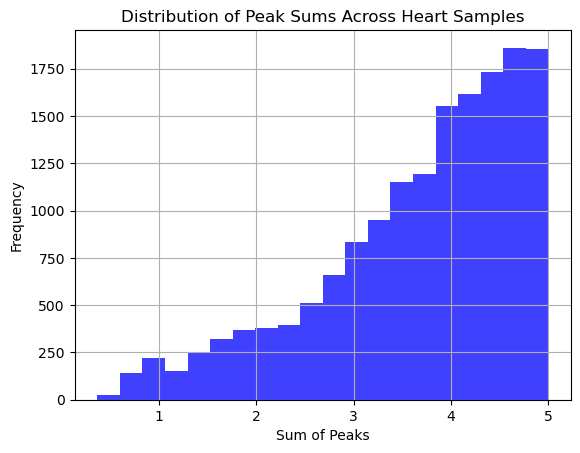

In [12]:
# Visualize the Distribution
import matplotlib.pyplot as plt

# Plot a histogram of heart_peak_sum
plt.hist(filtered_df['heart_peak_sum'], bins=20, alpha=0.75, color='blue')
plt.title('Distribution of Peak Sums Across Heart Samples')
plt.xlabel('Sum of Peaks')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

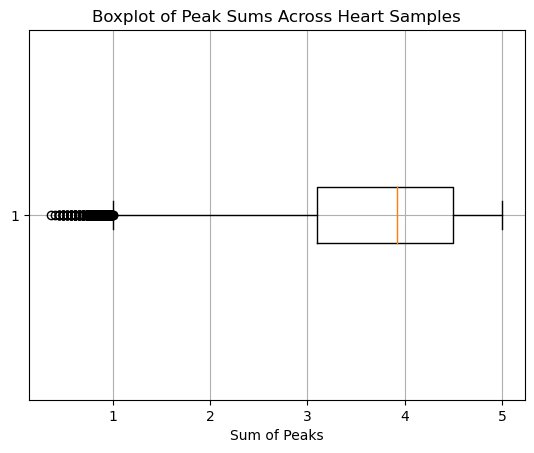

In [13]:
# Plot a boxplot of heart_peak_sum
plt.boxplot(filtered_df['heart_peak_sum'], vert=False)
plt.title('Boxplot of Peak Sums Across Heart Samples')
plt.xlabel('Sum of Peaks')
plt.grid(True)
plt.show()

### Create Heart_Specific binary label

In [14]:
filtered_df['Heart_Specific'] = (filtered_df['heart_peak_sum'] >= 4).astype(int)
# Create a new DataFrame with just sequences and the new heart-specific label
sequences_df = filtered_df[['dhs_id', 'sequence', 'Heart_Specific']]

# Now sequences_df contains just the sequences and a binary label for heart tissue specificity

In [15]:
sequences_df

,dhs_id,sequence,Heart_Specific
0,chr11_121255621_121255836_121255730,CAGGGTGATAAGCATATCAGTGAGTGATGAGCAGGGGTTAGGGCAA...,1
1,chr12_126348340_126348520_126348430,TTATTTTCTGAGTGGAGAGACCAAATGCATGTGATTTGATGAGCCT...,1
2,chr1_181043582_181043786_181043690,AGCTACTCAGGAGGCTGAGGTGAGAGGACCACTTAAGCCCAGGAAT...,1
3,chr2_172561260_172561540_172561390,ATTAAGAGGAAATTAAGGGTTAAAGCAAAGCAGCAGCTGCTATCAG...,1
4,chr8_20998020_20998280_20998140,AGGCTTTCATGCTTCTCATCTGGTACTTTCCATTTCTCAAGTGGCG...,1
...,...,...,...
3586839,chr2_214809140_214809517_214809370,CCGGCAGGTGCTAACCGCACGCCGACCCGACTGCAGCGCGGGAACG...,0
3586840,chr2_100821061_100821400_100821210,AGGTCGGTAACCAGGGAAGGGACAGGCACCACCCGGCTAAATTCAG...,1
3586841,chr4_182289289_182289500_182289390,TGAAACATTTGTCCAGTTTAGATAAAGGACTTACTCTATCTACAGC...,0
3586842,chr5_38530105_38530240_38530170,TGTCTATGGAGACAAGGCAGTGCTGGCAGGGGATGGGCCTGGGAGG...,0


In [16]:
# Assuming filtered_df is your DataFrame and is already loaded
# Identify columns that are heart-related (here I assume all provided columns are heart-specific)
heart_columns = [col for col in filtered_df.columns if 'Heart' in col or 'Cardiovascular' in col]

# Define a binary label for each sequence
# A sequence is labeled '1' if it has a peak in any of the heart columns, '0' otherwise
filtered_df['Heart_Specific'] = (filtered_df[heart_columns].sum(axis=1) > 5).astype(int)

# Create a new DataFrame with just sequences and the new heart-specific label
sequences_df = filtered_df[['dhs_id','sequence', 'Heart_Specific']]

# Now sequences_df contains just the sequences and a binary label for heart tissue specificity


In [17]:
sequences_df

,dhs_id,sequence,Heart_Specific
0,chr11_121255621_121255836_121255730,CAGGGTGATAAGCATATCAGTGAGTGATGAGCAGGGGTTAGGGCAA...,1
1,chr12_126348340_126348520_126348430,TTATTTTCTGAGTGGAGAGACCAAATGCATGTGATTTGATGAGCCT...,1
2,chr1_181043582_181043786_181043690,AGCTACTCAGGAGGCTGAGGTGAGAGGACCACTTAAGCCCAGGAAT...,1
3,chr2_172561260_172561540_172561390,ATTAAGAGGAAATTAAGGGTTAAAGCAAAGCAGCAGCTGCTATCAG...,1
4,chr8_20998020_20998280_20998140,AGGCTTTCATGCTTCTCATCTGGTACTTTCCATTTCTCAAGTGGCG...,1
...,...,...,...
3586839,chr2_214809140_214809517_214809370,CCGGCAGGTGCTAACCGCACGCCGACCCGACTGCAGCGCGGGAACG...,0
3586840,chr2_100821061_100821400_100821210,AGGTCGGTAACCAGGGAAGGGACAGGCACCACCCGGCTAAATTCAG...,1
3586841,chr4_182289289_182289500_182289390,TGAAACATTTGTCCAGTTTAGATAAAGGACTTACTCTATCTACAGC...,0
3586842,chr5_38530105_38530240_38530170,TGTCTATGGAGACAAGGCAGTGCTGGCAGGGGATGGGCCTGGGAGG...,0


In [18]:
# Let's see how many DHSs are classified as heart-specific
sequences_label_1 =sequences_df[sequences_df['Heart_Specific']==1]
sequences_label_1

,dhs_id,sequence,Heart_Specific
0,chr11_121255621_121255836_121255730,CAGGGTGATAAGCATATCAGTGAGTGATGAGCAGGGGTTAGGGCAA...,1
1,chr12_126348340_126348520_126348430,TTATTTTCTGAGTGGAGAGACCAAATGCATGTGATTTGATGAGCCT...,1
2,chr1_181043582_181043786_181043690,AGCTACTCAGGAGGCTGAGGTGAGAGGACCACTTAAGCCCAGGAAT...,1
3,chr2_172561260_172561540_172561390,ATTAAGAGGAAATTAAGGGTTAAAGCAAAGCAGCAGCTGCTATCAG...,1
4,chr8_20998020_20998280_20998140,AGGCTTTCATGCTTCTCATCTGGTACTTTCCATTTCTCAAGTGGCG...,1
...,...,...,...
3586817,chr22_41582940_41583136_41583030,GCACATCAAGGTTTAGCAGGGGCAGTACAGGCAGAGGTGAGAGGAC...,1
3586823,chr11_119321260_119321500_119321390,CGCAGGGGGCGTCTCGGGGCTGCCTCCTGGGTAGGCAATGAGGCTG...,1
3586829,chr10_45626015_45626186_45626090,GGAGGTTTGTAGACAGCCCAGTTCCAGAGTTCTGAAGCCTGCCTGC...,1
3586840,chr2_100821061_100821400_100821210,AGGTCGGTAACCAGGGAAGGGACAGGCACCACCCGGCTAAATTCAG...,1


In [19]:
# Let's see how many DHSs are classified as heart-specific
sequences_label_0 =sequences_df[sequences_df['Heart_Specific']==0]
sequences_label_0

,dhs_id,sequence,Heart_Specific
20,chr8_142940055_142940260_142940150,CCTTGTGGACGTGATAGGCTGGGACTGAGGGGAGGAAGCGTGAGGC...,0
33,chr1_30278720_30279080_30278870,AGGGATTTGAGAGCATCCCAACAGCCAGTGAGTGGCTGAGCAGGAT...,0
36,chr12_53075820_53076118_53075980,TCCCACCCTTACCCTGCAAGGGCCAGCACACAGGAGAATCCATCAG...,0
40,chr13_95514600_95514820_95514700,CAGGTAGCCTCAAGGGTCTTCTAGCACTTGTCAGCAGGTGAGAGTA...,0
41,chr7_50937800_50938020_50937910,CAGCTCCAGCTCTCCATTTCATATCAGTGAGGCCACACTTCAGTGT...,0
...,...,...,...
3586837,chr15_69482800_69483060_69482930,CAGCTCTGGGCTTTACGCCAGGATCTCAGGCTGGCAAATTGGAATA...,0
3586838,chr13_45799622_45799830_45799730,TGGTAGTGGAGCTGGGCTTTGATGCTCTGGATTCTGGCTGCAGAGT...,0
3586839,chr2_214809140_214809517_214809370,CCGGCAGGTGCTAACCGCACGCCGACCCGACTGCAGCGCGGGAACG...,0
3586841,chr4_182289289_182289500_182289390,TGAAACATTTGTCCAGTTTAGATAAAGGACTTACTCTATCTACAGC...,0


### We have a pretty balanced dataset now

In [20]:
sequences_df.to_feather("heart_specific_dhs_sequences.ftr")

In [3]:
sequences_df.to_csv("../DNABERT/examples/dhs/heart_specific_dhs_sequences.tsv",sep='\t', index=False, header=True)

### Now let's generate k-mers (k=6) to use the DNABERT model trained on 6-mers

In [21]:
# Generate 6-mers from the original 'sequence' column and replace it
sequences_df['sequence'] = sequences_df['sequence'].apply(lambda x: ' '.join([x[i:i+6] for i in range(len(x) - 6 + 1)]))

# Rename 'Heart_Specific' to 'label'
sequences_df.rename(columns={'Heart_Specific': 'label'}, inplace=True)

# Ensure the DataFrame only contains the columns 'dhs_id', 'sequence', and 'label', in that order
sequences_df = sequences_df[['dhs_id', 'sequence', 'label']]

sequences_df

/tmp/ipykernel_48791/1458421874.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sequences_df['sequence'] = sequences_df['sequence'].apply(lambda x: ' '.join([x[i:i+6] for i in range(len(x) - 6 + 1)]))
/tmp/ipykernel_48791/1458421874.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sequences_df.rename(columns={'Heart_Specific': 'label'}, inplace=True)


,dhs_id,sequence,label
0,chr11_121255621_121255836_121255730,CAGGGT AGGGTG GGGTGA GGTGAT GTGATA TGATAA GATA...,1
1,chr12_126348340_126348520_126348430,TTATTT TATTTT ATTTTC TTTTCT TTTCTG TTCTGA TCTG...,1
2,chr1_181043582_181043786_181043690,AGCTAC GCTACT CTACTC TACTCA ACTCAG CTCAGG TCAG...,1
3,chr2_172561260_172561540_172561390,ATTAAG TTAAGA TAAGAG AAGAGG AGAGGA GAGGAA AGGA...,1
4,chr8_20998020_20998280_20998140,AGGCTT GGCTTT GCTTTC CTTTCA TTTCAT TTCATG TCAT...,1
...,...,...,...
3586839,chr2_214809140_214809517_214809370,CCGGCA CGGCAG GGCAGG GCAGGT CAGGTG AGGTGC GGTG...,0
3586840,chr2_100821061_100821400_100821210,AGGTCG GGTCGG GTCGGT TCGGTA CGGTAA GGTAAC GTAA...,1
3586841,chr4_182289289_182289500_182289390,TGAAAC GAAACA AAACAT AACATT ACATTT CATTTG ATTT...,0
3586842,chr5_38530105_38530240_38530170,TGTCTA GTCTAT TCTATG CTATGG TATGGA ATGGAG TGGA...,0


In [22]:
# That's our final dataset
sequences_df.to_feather("heart_specific_dhs_6mers.ftr")

# Saving the data for DNABERT training
We must <b>clone the DNABERT repo</b> and <b><u>set up the environment</u></b> using instructions from the [official DNABERT site](https://github.com/jerryji1993/DNABERT), one level above the current working directory. Hence you will have a folder DNABERT one level above your current working folder, i.e. <b>../DNABERT/</b>

We must next create the subfolder ```/dhs/ft/6/``` in the folder in the folder ```../DNABERT/examples/```

We will next save our datasets for training and testing in the new folder ```../DNABERT/examples/dhs/ft/6/```

In [5]:
sequences_df.to_csv('../DNABERT/examples/dhs/ft/6/heart_specific_dhs_6mers_with_dhs_ids.tsv', sep='\t', index=False)

In [6]:
sequences_df_no_id=sequences_df[['sequence', 'label']]
sequences_df_no_id.to_csv('../DNABERT/examples/dhs/ft/6/heart_specific_dhs_6mers.tsv', sep='\t', index=False)

## Using DNABERT
### 1. Finetuning the DNABERT kmer 6 model
In case we want to finetune the pretrained DNABERT model, we must have the Train and Test datasets such that we can finetune the pre-trained DNABERT model using kmers=6 using the train data and test using the test dataset.

### 2. Using the finetuned pre-trained DNABERT model
In case we wish to use the pre-trained finetuned model using kmers=6, we must download it from the [drive specified in the DNABERT repo](https://drive.google.com/drive/folders/15wFcukTv3ecPw9_25dcOv-bZmj-8d_-6). That drive contains a folder named <b>dna_model</b> with 5 files. We must download the folder dna_model and save it in our folder ```../DNABERT/examples/dhs/ft/6/```.

If using the finetuned pretrained DNABERT model, we will use the whole dataset to make predictions.

### Next we have to create the train, test datasets and save.

In [7]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
train_df, test_df = train_test_split(sequences_df, test_size=0.2, random_state=42)

# Save the training and testing sets to .tsv files
train_df.to_csv('../DNABERT/examples/dhs/ft/6/heart_specific_dhs_6mers_train.tsv', sep='\t', index=False, header=False)
test_df.to_csv('../DNABERT/examples/dhs/ft/6/heart_specific_dhs_6mers_test.tsv', sep='\t', index=False, header=False)

## Important Note
When running prediction, the data that has to be used for prediction must be named <b>dev.tsv</b> in folder:
../DNABERT/examples/dhs/ft/6/